# 使用 PyTorch 训练神经网络入门

本教程将引导你完成一个完整的神经网络训练流程，包括：
1. **定义网络结构**：构建一个简单的卷积神经网络 (CNN)。
2. **准备数据**：使用 `torchvision` 加载并预处理 CIFAR-10 数据集。
3. **定义损失函数和优化器**：选择模型训练所需的核心组件。
4. **训练模型**：编写标准的训练循环，通过迭代来优化模型参数。
5. **评估模型**：在测试集上检验模型的性能。

这是一个非常经典且标准的流程，掌握它将为你后续学习更复杂的模型打下坚实的基础。

## 第0步：导入所有必要的库

将所有需要用到的库放在开头，是一个很好的编程习惯。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

## 第1步：定义神经网络结构 (CNN)

我们定义一个简单的卷积神经网络。这个结构包含两个卷积层和三个全连接层，用于处理输入的图像。

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 定义第一个卷积层：输入通道为3（彩色图像），输出通道为6，卷积核大小为5x5
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # 定义一个最大池化层：窗口大小为2x2
        self.pool = nn.MaxPool2d(2, 2)
        # 定义第二个卷积层：输入通道为6（上一层的输出），输出通道为16，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 定义全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 最后的输出是10个类别

    def forward(self, x):
        # 定义数据如何“流经”你声明的那些层 (前向传播)
        # 卷积 -> 激活 -> 池化
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 将多维张量“压平”成一维向量
        x = x.view(-1, 16 * 5 * 5)
        # 全连接层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 实例化网络
net = SimpleCNN()
print("网络结构:")
print(net)

网络结构:
SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 第2步：准备数据 (Dataset & DataLoader)

我们使用 PyTorch 内置的 `CIFAR-10` 数据集。在加载数据时，我们会进行必要的预处理，例如将图像转换为 Tensor 并进行归一化。

`DataLoader` 会帮我们自动处理数据批次 (mini-batch) 和随机排序 (shuffle)。

In [4]:
# 定义数据预处理：将图片转换为 Tensor，并进行归一化
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 归一化到 [-1, 1] 区间

batch_size = 4 # 设定每个批次包含4张图片

# 下载并加载训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# 下载并加载测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# 定义10个类别
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|████████████████████████| 170498071/170498071 [01:12<00:00, 2360089.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### 可视化部分数据

让我们看几张训练集中的图片，直观感受一下。

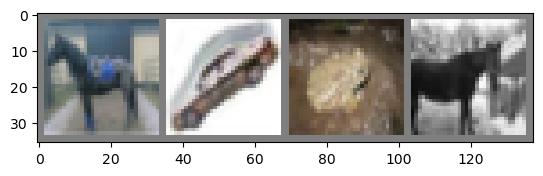

horse car   frog  horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机获取一些训练数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 第3步：定义损失函数和优化器

- **损失函数 (Loss Function)**: 我们选择交叉熵损失 `nn.CrossEntropyLoss`，因为它非常适合多分类任务。
- **优化器 (Optimizer)**: 我们选择带动量的随机梯度下降 `optim.SGD`。

In [6]:
# 检查是否有可用的 GPU，并设置设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"将使用设备: {device}")

# 将网络移动到指定设备
net.to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

将使用设备: cuda:0


## 第4步：训练模型

这是最核心的步骤。我们将遍历数据集多轮（epochs），在每一轮中：
1. 从 `trainloader` 获取一个批次的数据。
2. 将历史梯度清零 (`optimizer.zero_grad()`)。
3. **前向传播**：模型进行预测。
4. **计算损失**：比较预测和真实标签。
5. **反向传播**：计算梯度 (`loss.backward()`)。
6. **更新参数**：优化器根据梯度调整模型权重 (`optimizer.step()`)。

In [11]:
num_epochs = 2  # 为了快速演示，我们只训练2轮

for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取一个批次的数据，并移动到指定设备
        inputs, labels = data[0].to(device), data[1].to(device)

        # 梯度清零
        optimizer.zero_grad()

        # 前向传播 -> 反向传播 -> 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每 2000 个 mini-batches 打印一次损失
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.191
[1,  4000] loss: 1.192
[1,  6000] loss: 1.170
[1,  8000] loss: 1.182
[1, 10000] loss: 1.169
[1, 12000] loss: 1.152
[2,  2000] loss: 1.092
[2,  4000] loss: 1.075
[2,  6000] loss: 1.086
[2,  8000] loss: 1.091
[2, 10000] loss: 1.097
[2, 12000] loss: 1.083
Finished Training


#### 保存我们训练好的模型

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 第5步：在测试集上评估模型

现在，我们将用模型从未见过的测试数据来检验它的泛化能力。
在评估阶段，我们不需要计算梯度，所以会使用 `torch.no_grad()` 来节约计算资源并防止意外的参数更新。

In [9]:
correct = 0
total = 0

# 切换到评估模式
net.eval()

# 在评估时，我们不希望计算梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # 前向传播，得到模型的预测输出
        outputs = net(images)
        # 获取预测结果：取概率最高的那个类别的索引
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


#### 查看每个类别的准确率

整体准确率有时候会掩盖模型在某些类别上的表现好坏。让我们分别看看每个类别的表现。

In [10]:
# 准备统计每个类别的预测情况
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 统计每个类别的正确预测数
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 打印每个类别的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.8 %
Accuracy for class: car   is 84.7 %
Accuracy for class: bird  is 49.0 %
Accuracy for class: cat   is 37.4 %
Accuracy for class: deer  is 36.4 %
Accuracy for class: dog   is 41.7 %
Accuracy for class: frog  is 74.7 %
Accuracy for class: horse is 58.8 %
Accuracy for class: ship  is 72.7 %
Accuracy for class: truck is 46.3 %


# PyTorch中的`device`：CPU与GPU的协同工作

在PyTorch中，`device` 的管理是决定代码能否利用 GPU 高效运行的关键。本教程将详细解释 `device` 的 **“是什么”**、**“为什么”** 和 **“怎么做”**。

理解并正确使用 `device` 是从PyTorch入门到熟练的必经之路。

## 1. `device` 是什么？(What?)

`device` 在 PyTorch 中是一个对象 (`torch.device`)，它代表了 **张量 (Tensors) 和模型 (Models) 将要被存储和计算的地方**。

你可以把它想象成一个“计算车间”的地址：
* `device = torch.device('cpu')`：代表你的“CPU 车间”。这是默认选项，所有电脑都有。它像一个万能的手工工作台，什么都能做，但速度较慢。
* `device = torch.device('cuda')`：代表你的“GPU 车间”。`cuda` 是 NVIDIA 显卡的并行计算平台。它像一条高度专业化的流水线，特别擅长大规模、并行的矩阵运算，速度极快。通常也写作 `cuda:0`，表示第一块 GPU。

### 核心规则
**任何需要进行交互计算的张量和模型，都必须在 *同一个 `device`* 上。** 否则 PyTorch 就会报错。就像你不能让 CPU 车间的零件，直接被 GPU 流水线上的机器使用一样，必须先把零件搬过去。

## 2. 为什么需要 `device`？(Why?)

深度学习训练的核心是海量的矩阵乘法和加法。

* **CPU (Central Processing Unit)**：核心数少（比如 4 核、8 核），但每个核心都非常强大和通用，擅长处理复杂的逻辑和串行任务。用它来做大规模矩阵运算，就像让一个博士去做几百万次小学生的加法，虽然能做对，但效率极低。
* **GPU (Graphics Processing Unit)**：拥有成百上千个小核心。每个核心虽然不如 CPU 核心强大，但它们可以同时进行简单的计算。这使得 GPU 在处理像矩阵乘法这样可以高度并行的任务时，速度比 CPU **快几十甚至几百倍**。

所以，我们通过指定 `device='cuda'`，就是告诉 PyTorch：“请把这个模型和这些数据都搬到 GPU 上，然后利用 GPU 的并行计算能力来加速我的训练过程。”

## 3. 应该怎么做？(How?)

在代码中正确地管理 `device` 通常遵循一个标准的 **“三步走”** 流程。

### 第1步：在代码开头定义 `device`

我们通常会在脚本的开头就检查 GPU 是否可用，并定义一个全局的 `device` 变量。这让你的代码更具可移植性——在有 GPU 的机器上它会自动使用 GPU，在没有 GPU 的机器上则会平稳地切换到 CPU。

这是 **“模板代码”**，几乎所有 PyTorch 项目都会这样写：

In [ ]:
import torch
import torch.nn as nn

# 检查 torch.cuda 是否可用 (即你的电脑是否有可用的 NVIDIA GPU 和正确的驱动)
# 如果可用，我们就定义 device 为 'cuda'，否则就是 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'将要使用的设备是: {device}')

### 第2步：将你的模型移动到 `device`

在你创建了模型实例之后，你需要立刻将它移动到我们定义的 `device` 上。这个操作会将模型的所有参数（权重和偏置，它们本身也是张量）都搬到对应的设备内存中。

这个操作对一个模型实例 **只需要做一次**。

In [ ]:
# 1. 先定义一个简单的网络结构用于演示
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(10, 20)
        self.layer2 = nn.Linear(20, 5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# 2. 实例化模型
model = SimpleNet()
print(f"模型实例化后, 参数 'layer1.weight' 所在的设备是: {next(model.parameters()).device}")

# 3. 使用 .to() 方法将整个模型的所有参数和缓冲区移动到指定设备
model.to(device)
print(f"模型移动后, 参数 'layer1.weight' 所在的设备是: {next(model.parameters()).device}")

### 第3步：在训练循环中，将你的数据移动到 `device`

模型已经被搬到目标设备上了。现在，为了让模型能处理数据，每一批次（mini-batch）的数据在送入模型之前，也必须被搬到同一个 `device` 上。

这个操作是在 **训练循环内部** 完成的，因为数据是分批次加载的。

In [ ]:
# 1. 假设这是从 DataLoader 中取出的一个批次的数据
inputs = torch.randn(4, 10) # 4个样本，每个样本10个特征
labels = torch.randint(0, 5, (4,))

print(f"原始 'inputs' 张量所在的设备是: {inputs.device}")
print(f"原始 'labels' 张量所在的设备是: {labels.device}")

# 2. 关键一步：将输入数据和标签也移动到和模型一样的设备上
inputs_on_device = inputs.to(device)
labels_on_device = labels.to(device)

print(f"移动后 'inputs' 张量所在的设备是: {inputs_on_device.device}")
print(f"移动后 'labels' 张量所在的设备是: {labels_on_device.device}")

# 3. 现在，模型和数据都在同一个设备上，可以进行计算了
# outputs = model(inputs_on_device) # 这行代码现在可以正确执行

## 总结与常见错误

#### 总结流程
1.  **脚本开头**：`device = torch.device(...)` -> 定义目标车间。
2.  **模型实例化后**：`model.to(device)` -> 把流水线搬到目标车间。
3.  **训练循环内**：`inputs.to(device)`, `labels.to(device)` -> 把每一批零件搬到目标车间，交给流水线处理。

#### 最常见的错误
如果你忘记将模型或数据移动到同一个 `device`，就会遇到这样的运行时错误：

**`RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!`**

当你看到这个错误时，第一反应就应该是检查你的代码，看看是哪个张量（可能是 `model` 的参数，也可能是 `inputs` 或 `labels`）忘记了使用 `.to(device)`。